<a href="https://colab.research.google.com/github/J-Gann/medfluencer/blob/main/medfluencer_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis Medfluencer


In [1]:
%%capture
%pip install -U llama-index-vector-stores-pinecone
%pip install -U llama-index pinecone-client
%pip install -U scikit-learn
%pip install -U umap-learn
%pip install -U transformers sentence-transformers
%pip install anthropic
%pip install llama-index-embeddings-huggingface

In [3]:
from pinecone import Pinecone
from llama_index.vector_stores.pinecone import PineconeVectorStore
from llama_index.core import StorageContext, VectorStoreIndex
import pickle
import umap
import matplotlib.pyplot as plt
from sklearn import datasets, cluster
from sklearn.cluster import HDBSCAN
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from scipy.spatial import ConvexHull
import os
from anthropic import Anthropic
from collections import Counter
from nltk.tokenize import word_tokenize
import numpy as np
import json
from tqdm.auto import tqdm
import csv
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from collections import Counter
import copy
from google.colab import userdata

ANTHROPIC_API_KEY = userdata.get("ANTHROPIC_API_KEY")
PINECONE_API_KEY = userdata.get("PINECONE_API_KEY")
GITHUB_TOKEN = userdata.get('GITHUB_TOKEN')

In [4]:
client = Anthropic(api_key=ANTHROPIC_API_KEY)

In [5]:
embed_model = HuggingFaceEmbedding(
    model_name="T-Systems-onsite/cross-en-de-roberta-sentence-transformer"
)

config.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [6]:
!git clone https://$GITHUB_TOKEN@github.com/J-Gann/medfluencer.git

Cloning into 'medfluencer'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 37 (delta 1), reused 37 (delta 1), pack-reused 0
Receiving objects: 100% (37/37), 2.99 MiB | 25.95 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Filtering content: 100% (21/21), 10.85 GiB | 110.70 MiB/s, done.


In [41]:
# extract all medical terms from MESH dataset
medical_terms = []
with open("medfluencer/mesh/MH.TXT", "r") as file:
    csv_reader = csv.reader(file, delimiter=";")
    for row in csv_reader:
        medical_terms.append(row[1][1:-1].lower())
medical_terms = set(medical_terms)
medical_terms.remove("es")
medical_terms.remove(
    "kind"
)  # duplicate meaning in en and de => would lead to lots of "child related" deseases later on
medical_terms.remove("seen")
medical_terms.remove("liebe") # occurs very often in comments to indicate support (not really medical topic)

## Analysis of Videos


In [8]:
with open("medfluencer/scraping/videos_scraping.json", "r") as f:
    videos_data = json.load(f)

In [ ]:
# processed_video_data = []
# processed_video_ids = []
# for video_id, video in videos_data.items():
#    if video["transcription"] is None:
#        continue
#    if video["description"] is None:
#        continue
#    if video["title"] is None:
#        continue
#    processed_video_ids.append(video_id)
#    processed_video_data.append(video)

In [ ]:
# video_transcriptions = [video["transcription"] for video in processed_video_data]
# video_descriptions = [video["description"] for video in processed_video_data]
# video_titles = [video["title"] for video in processed_video_data]

In [12]:
# import concurrent.futures
#
# def get_video_description_embeddings():
#    return embed_model.get_text_embedding_batch(video_descriptions, show_progress=True)
#
# def get_video_title_embeddings():
#    return embed_model.get_text_embedding_batch(video_titles, show_progress=True)
#
# def get_video_transcription_embeddings():
#    return embed_model.get_text_embedding_batch(video_transcriptions, show_progress=True)
#
# with concurrent.futures.ThreadPoolExecutor() as executor:
#    future_description = executor.submit(get_video_description_embeddings)
#    future_title = executor.submit(get_video_title_embeddings)
#    future_transcription = executor.submit(get_video_transcription_embeddings)
#
#    video_description_embeddings = future_description.result()
#    video_title_embeddings = future_title.result()
#    video_transcription_embeddings = future_transcription.result()

# video_description_embeddings = np.array(video_description_embeddings)
# video_transcription_embeddings = np.array(video_transcription_embeddings)
# video_title_embeddings = np.array(video_title_embeddings)
# processed_video_ids = np.array(processed_video_ids)

In [14]:
# with open("medfluencer/embeddings/video_description_embeddings.npy", "wb") as f:
#    np.save(f, video_description_embeddings)
#
# with open("medfluencer/embeddings/video_transcription_embeddings.npy", "wb") as f:
#    np.save(f, video_transcription_embeddings)
#
# with open("medfluencer/embeddings/video_title_embeddings.npy", "wb") as f:
#    np.save(f, video_title_embeddings)
#
# with open("medfluencer/embeddings/video_ids.npy", "wb") as f:
#    np.save(f, processed_video_ids)

In [15]:
with open("medfluencer/embeddings/video_description_embeddings.npy", "rb") as f:
    video_description_embeddings = np.load(f)

with open("medfluencer/embeddings/video_transcription_embeddings.npy", "rb") as f:
    video_transcription_embeddings = np.load(f)

with open("medfluencer/embeddings/video_title_embeddings.npy", "rb") as f:
    video_title_embeddings = np.load(f)

with open("medfluencer/embeddings/video_ids.npy", "rb") as f:
    video_ids = np.load(f)

videos = [videos_data[video_id] for video_id in video_ids]

In [ ]:
# reducer = umap.UMAP(metric="cosine", n_neighbors=30)
# video_description_embeddings_2d = reducer.fit_transform(video_description_embeddings)
# with open("medfluencer/evaluation/video_description_embeddings_2d.npy", "wb") as f:
#    np.save(f, video_description_embeddings_2d)

In [17]:
with open("medfluencer/evaluation/video_description_embeddings_2d.npy", "rb") as f:
   video_description_embeddings_2d = np.load(f)

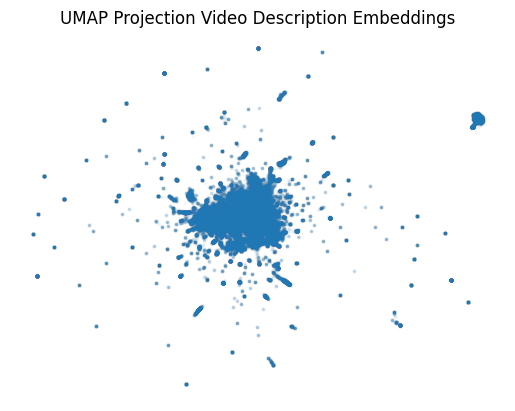

In [18]:
plt.scatter(
    video_description_embeddings_2d[:, 0],
    video_description_embeddings_2d[:, 1],
    marker=".",
    s=10,
    alpha=0.03,
)
plt.title("UMAP Projection Video Description Embeddings")
plt.axis("off")
plt.show()

In [ ]:
# clustering = HDBSCAN(min_cluster_size=50, max_cluster_size=10000).fit_predict(
#     video_description_embeddings_2d
# )

In [ ]:
# unique_clusters = np.unique(clustering)
# n_clusters = len(unique_clusters)
# n_clusters

213

In [ ]:
# terms = {}
#
# def get_most_frequent_medical_term(transcriptions):
#     all_medical_words = []
#     for transcription in transcriptions:
#         words = (
#             transcription.lower()
#             .replace(",", " ")
#             .replace(".", " ")
#             .replace("\n", " ")
#             .split()
#         )
#         medical_words = list(filter(lambda x: x in medical_terms, words))
#         all_medical_words.extend(medical_words)
#
#     counter = Counter(all_medical_words)
#     most_common_word = counter.most_common(15)
#     return most_common_word
#
#
# for cluster in unique_clusters[1:]:
#     cluster_indices = np.where(clustering == cluster)[0]
#     transcriptions = [videos[idx]["transcription"] for idx in cluster_indices]
#     words = get_most_frequent_medical_term(transcriptions)
#
#     message = client.messages.create(
#         max_tokens=4096,
#         messages=[
#             {
#                 "role": "user",
#                 "content": "You recieve a list of words along with the number of their occurence in a text. Suggest a medical topic of the underlying text with one or two german words. Only answer with the described topic!\n"
#                 + str(words),
#             }
#         ],
#         model="claude-3-5-sonnet-20240620",
#         temperature=0,
#     )
#     print(f"{message.content[0].text}: {str(words)}")
#     terms[cluster] = message.content[0].text

Krebsprävention: [('therapie', 28), ('menschen', 26), ('risikofaktoren', 20), ('risiko', 20), ('patienten', 19), ('rauchen', 18), ('haut', 15), ('deutschland', 15), ('blut', 15), ('übergewicht', 13), ('prostata', 12), ('ernährung', 11), ('sehen', 9), ('zeit', 9), ('wasser', 9)]
Handchirurgie: [('depression', 122), ('finger', 115), ('humerus', 109), ('hand', 104), ('ulna', 55), ('radius', 52), ('arm', 52), ('ego', 23), ('extension', 20), ('serotonin', 14), ('glucose', 10), ('curcumin', 9), ('pronation', 9), ('glutamate', 8), ('meditation', 8)]
Orthopädische Chirurgie: [('patienten', 80), ('schulter', 70), ('therapie', 61), ('knochen', 56), ('knorpel', 43), ('wirbelsäule', 35), ('sport', 32), ('hüftgelenk', 31), ('menschen', 30), ('schmerz', 30), ('hand', 29), ('gelenke', 28), ('rotatorenmanschette', 28), ('sehnen', 27), ('knie', 27)]
Depressive Störungen: [('depression', 70), ('lack', 9), ('motivation', 6), ('aggression', 3), ('internet', 3), ('temperament', 2), ('hand', 2), ('cannabis'

In [ ]:
# video_clustering = {
#    "clustering": clustering.tolist(),
#    "terms": list(terms.values()),
# }

In [ ]:
# with open("medfluencer/evaluation/video_clustering.json", "w") as f:
#    json.dump(video_clustering, f)

In [19]:
with open("medfluencer/evaluation/video_clustering.json", "r") as f:
    video_clustering = json.load(f)

In [20]:
clustering = video_clustering["clustering"]

In [21]:
terms = video_clustering["terms"]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


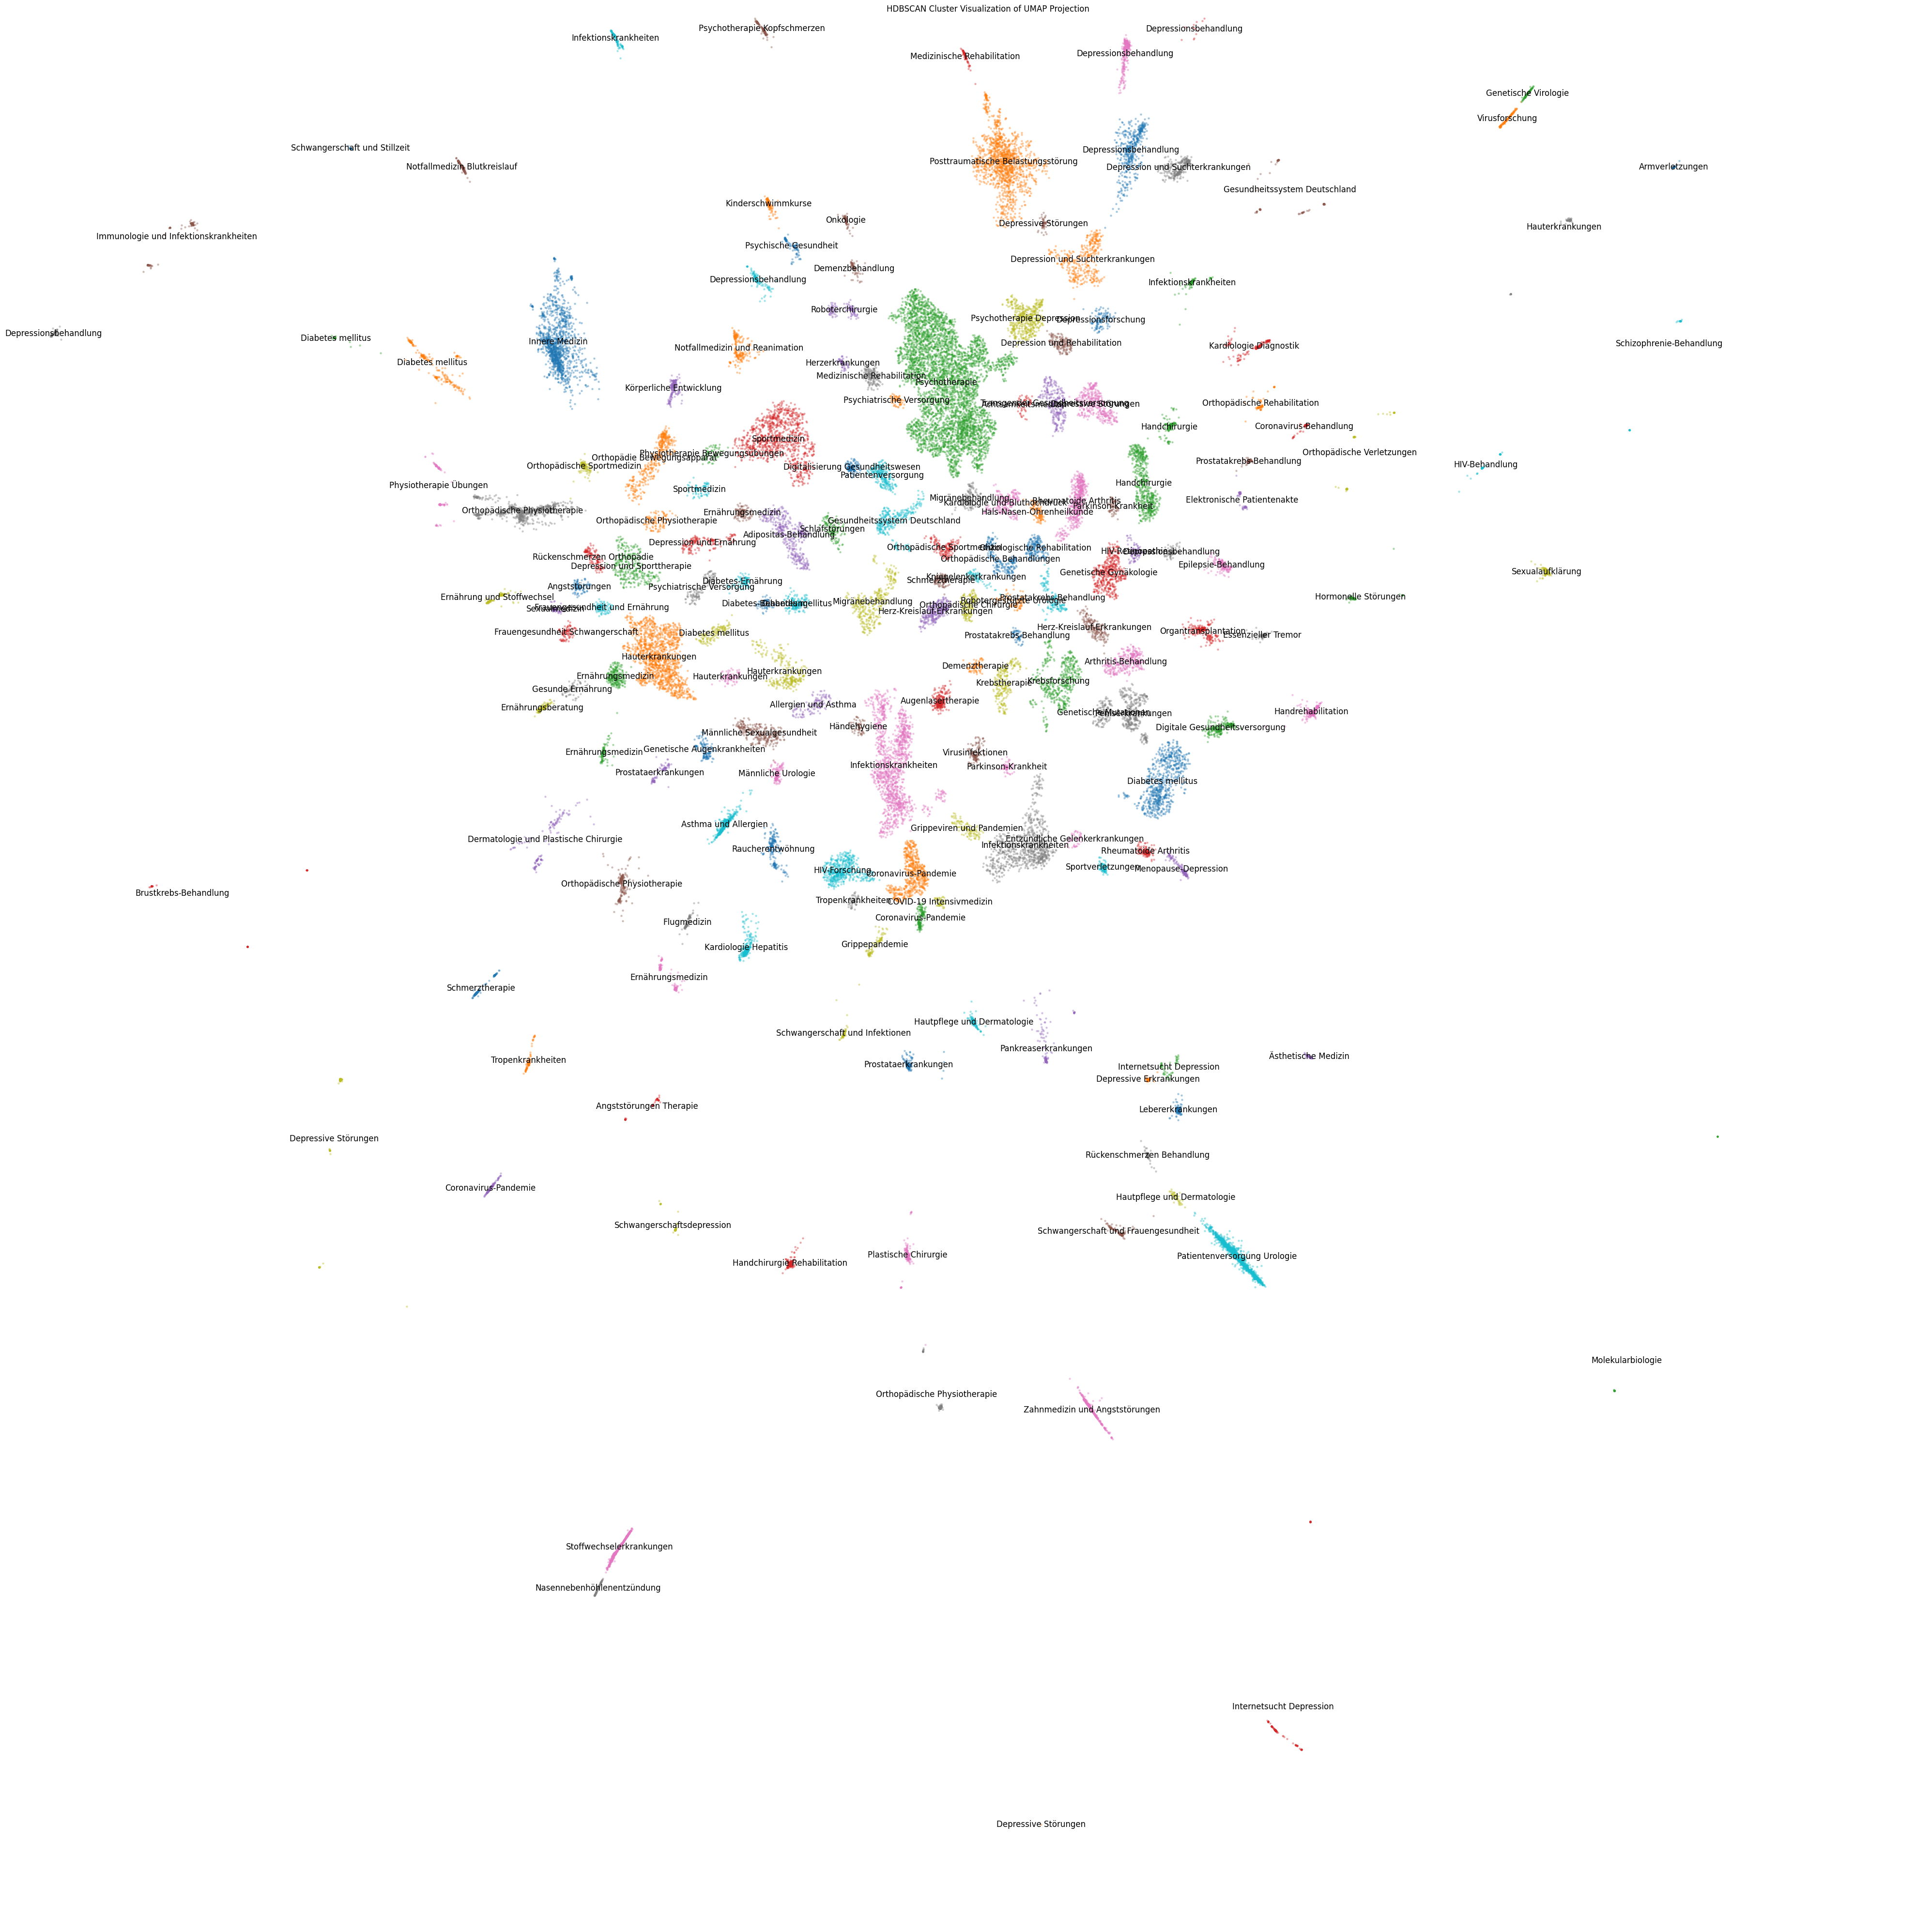

In [22]:
unique_clusters = np.unique(clustering)
n_clusters = len(unique_clusters)


def generate_distinct_colors(n):
    colors = plt.cm.rainbow(np.linspace(0, 1, n))
    return ListedColormap(colors)


custom_cmap = generate_distinct_colors(n_clusters)

fig, ax = plt.subplots(figsize=(40, 40))

x_min, x_max = plt.xlim(-10, 15)
y_min, y_max = plt.ylim(-10, 10)

for cluster in unique_clusters[1:]:
    embeddings = video_description_embeddings_2d[clustering == cluster]

    valid_indices = (
        (embeddings[:, 0] >= x_min)
        & (embeddings[:, 0] <= x_max)
        & (embeddings[:, 1] >= y_min)
        & (embeddings[:, 1] <= y_max)
    )

    embeddings = embeddings[valid_indices]

    scatter = ax.scatter(
        embeddings[:, 0],
        embeddings[:, 1],
        marker=".",
        s=20,
        alpha=0.3,
        label=f"cluster {cluster}",
    )

    centroid_x = np.mean(embeddings[:, 0])
    centroid_y = np.mean(embeddings[:, 1])

    # plt.text(centroid_x, centroid_y, str(cluster), fontsize=12, ha='center', va='center')
    plt.text(
        centroid_x,
        centroid_y,
        f"{terms[cluster]}",
        fontsize=12,
        ha="center",
        va="center",
    )

ax.set_title("HDBSCAN Cluster Visualization of UMAP Projection")
plt.axis("off")

plt.tight_layout()
plt.show()

## Analysis of Comments


In [31]:
with open("medfluencer/scraping/comments_scraping.json", "r") as f:
    comments_data = json.load(f)

In [32]:
comment_texts = [comment["text"] for comment_id, comment in comments_data.items()]

In [ ]:
# comment_embeddings = embed_model.get_text_embedding_batch(
#     comment_texts, show_progress=True
# )

Generating embeddings:   0%|          | 0/998721 [00:00<?, ?it/s]

In [ ]:
# num_parts = 4
# split_arrays = np.array_split(comment_embeddings, num_parts)
#
# filenames = []
# for i, split_array in enumerate(split_arrays):
#    filename = f"medfluencer/embeddings/comment_embeddings_part_{i + 1}.npy"
#    with open(filename, "wb") as f:
#        np.save(f, split_array)
#    filenames.append(filename)

In [23]:
num_parts = 4
data = []
for i in range(num_parts):
    filename = f"medfluencer/embeddings/comment_embeddings_part_{i + 1}.npy"
    with open(filename, "rb") as f:
        data_part = np.load(f)
        data.append(data_part)

comment_embeddings = np.concatenate(data)

In [ ]:
# reducer = umap.UMAP(metric="cosine", n_neighbors=30)
# comment_embeddings_2d = reducer.fit_transform(comment_embeddings)

In [24]:
with open("medfluencer/evaluation/comment_embeddings_2d.npy", "rb") as f:
    comment_embeddings_2d = np.load(f)

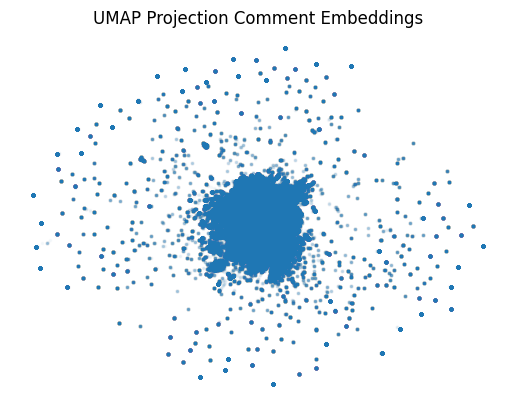

In [26]:
plt.scatter(
    comment_embeddings_2d[:, 0],
    comment_embeddings_2d[:, 1],
    marker=".",
    s=10,
    alpha=0.03,
)
plt.title("UMAP Projection Comment Embeddings")
plt.axis("off")
plt.show()

In [28]:
clustering = HDBSCAN(min_cluster_size=50, max_cluster_size=10000).fit_predict(
    comment_embeddings_2d
)

In [29]:
unique_clusters = np.unique(clustering)
n_clusters = len(unique_clusters)
n_clusters

1297

In [43]:
with open("medfluencer/evaluation/comment_embeddings_2d_clustering.npy", "wb") as f:
    np.save(f, clustering)

In [40]:
terms = {}


def get_most_frequent_medical_term(transcriptions):
    all_medical_words = []
    for transcription in transcriptions:
        words = (
            transcription.lower()
            .replace(",", " ")
            .replace(".", " ")
            .replace("\n", " ")
            .split()
        )
        medical_words = list(filter(lambda x: x in medical_terms, words))
        all_medical_words.extend(medical_words)

    counter = Counter(all_medical_words)
    most_common_word = counter.most_common(15)
    return most_common_word


for cluster in unique_clusters[1:]:
    cluster_indices = np.where(clustering == cluster)[0]
    transcriptions = [comment_texts[idx] for idx in cluster_indices]
    words = get_most_frequent_medical_term(transcriptions)

    total_count = sum([word[1] for word in words])

    if words != [] and total_count > 50:
        message = client.messages.create(
            max_tokens=4096,
            messages=[
                {
                    "role": "user",
                    "content": "You recieve a list of words along with the number of their occurence in a text. Suggest a medical topic of the underlying text with one or two german words. Only answer with the described topic!\n"
                    + str(words),
                }
            ],
            model="claude-3-5-sonnet-20240620",
            temperature=0,
        )
        print(f"{message.content[0].text}: {str(words)}")
        terms[cluster] = message.content[0].text
        print(str(words))
    else:
        terms[cluster] = ""
        if total_count <= 50:
            print("--- few")
        else:
            print("--- empty")


--- few
[('liebe', 69), ('vertrauen', 69), ('namen', 69)]
--- few
--- few
--- few
--- few
--- few
--- few
--- few
[('ratgeber', 40), ('drucken', 20), ('menschen', 20), ('bücher', 20), ('datenbanken', 20)]
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
[('ratgeber', 88), ('drucken', 44), ('menschen', 44), ('bücher', 44), ('datenbanken', 44), ('liebe', 3)]
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
[('ratgeber', 100), ('drucken', 50), ('menschen', 50), ('bücher', 50), ('datenbanken', 50)]
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- few
--- fe

In [ ]:
unique_clusters = np.unique(clustering)
n_clusters = len(unique_clusters)


def generate_distinct_colors(n):
    colors = plt.cm.rainbow(np.linspace(0, 1, n))
    return ListedColormap(colors)


custom_cmap = generate_distinct_colors(n_clusters)

fig, ax = plt.subplots(figsize=(40, 40))

x_min, x_max = plt.xlim(-10, 15)
y_min, y_max = plt.ylim(-10, 10)

for cluster in unique_clusters[1:]:
    embeddings = comment_embeddings_2d[clustering == cluster]

    valid_indices = (
        (embeddings[:, 0] >= x_min)
        & (embeddings[:, 0] <= x_max)
        & (embeddings[:, 1] >= y_min)
        & (embeddings[:, 1] <= y_max)
    )

    embeddings = embeddings[valid_indices]

    scatter = ax.scatter(
        embeddings[:, 0],
        embeddings[:, 1],
        marker=".",
        s=20,
        alpha=0.3,
        label=f"cluster {cluster}",
    )

    centroid_x = np.mean(embeddings[:, 0])
    centroid_y = np.mean(embeddings[:, 1])

    # plt.text(centroid_x, centroid_y, str(cluster), fontsize=12, ha='center', va='center')
    plt.text(
        centroid_x,
        centroid_y,
        f"{terms[cluster]}",
        fontsize=12,
        ha="center",
        va="center",
    )

ax.set_title("HDBSCAN Cluster Visualization of UMAP Projection")
plt.axis("off")

plt.tight_layout()
plt.show()

### Clustering of Transcriptions: Dimensionality Reduction with UMAP and CLustering with HDBSCAN


In [ ]:
# compute UMAP mapping
reducer = umap.UMAP(metric="cosine", n_neighbors=30)
embeddings_2d = reducer.fit_transform(embeddings)

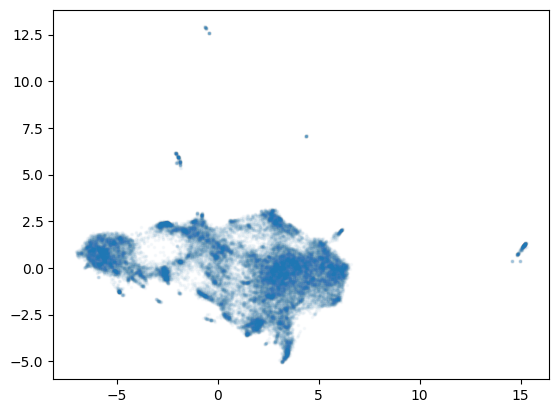

In [ ]:
# visualize mapping
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], marker=".", s=10, alpha=0.03)
plt.show()

In [ ]:
# cluster mapping with HDBSCAN
clustering = HDBSCAN(min_cluster_size=50, max_cluster_size=10000).fit_predict(
    embeddings_2d
)

In [ ]:
# compute cluster topics by evaluating content of cluster centroids

terms = {}

import numpy as np


def get_central_embedding(cluster_embeddings):
    """
    For a given cluster's embeddings, find the embedding that is closest to the centroid.
    """
    centroid = np.mean(cluster_embeddings, axis=0)
    distances = np.linalg.norm(cluster_embeddings - centroid, axis=1)
    return np.argsort(-distances)[:5]


for cluster in unique_clusters[1:]:
    cluster_embeddings = embeddings_2d[clustering == cluster]

    central_embeddin_index = get_central_embedding(cluster_embeddings)

    keys_list = list(all_vectors.keys())
    keys = [keys_list[idx] for idx in central_embeddin_index]
    txt = "".join(
        [
            json.loads(all_vectors[key]["metadata"]["_node_content"])["text"]
            for key in keys
        ]
    )
    message = client.messages.create(
        max_tokens=4096,
        messages=[
            {
                "role": "user",
                "content": "Answer with a SINGLE german word that best captures the general topic of the following text. Never answer with more than on SINGLE word!"
                + txt,
            }
        ],
        model="claude-3-5-sonnet-20240620",
        temperature=0,
    )
    terms[cluster] = message.content[0].text
    print(f"Cluster {cluster}: {message.content[0].text}")

<Figure size 1000x800 with 0 Axes>

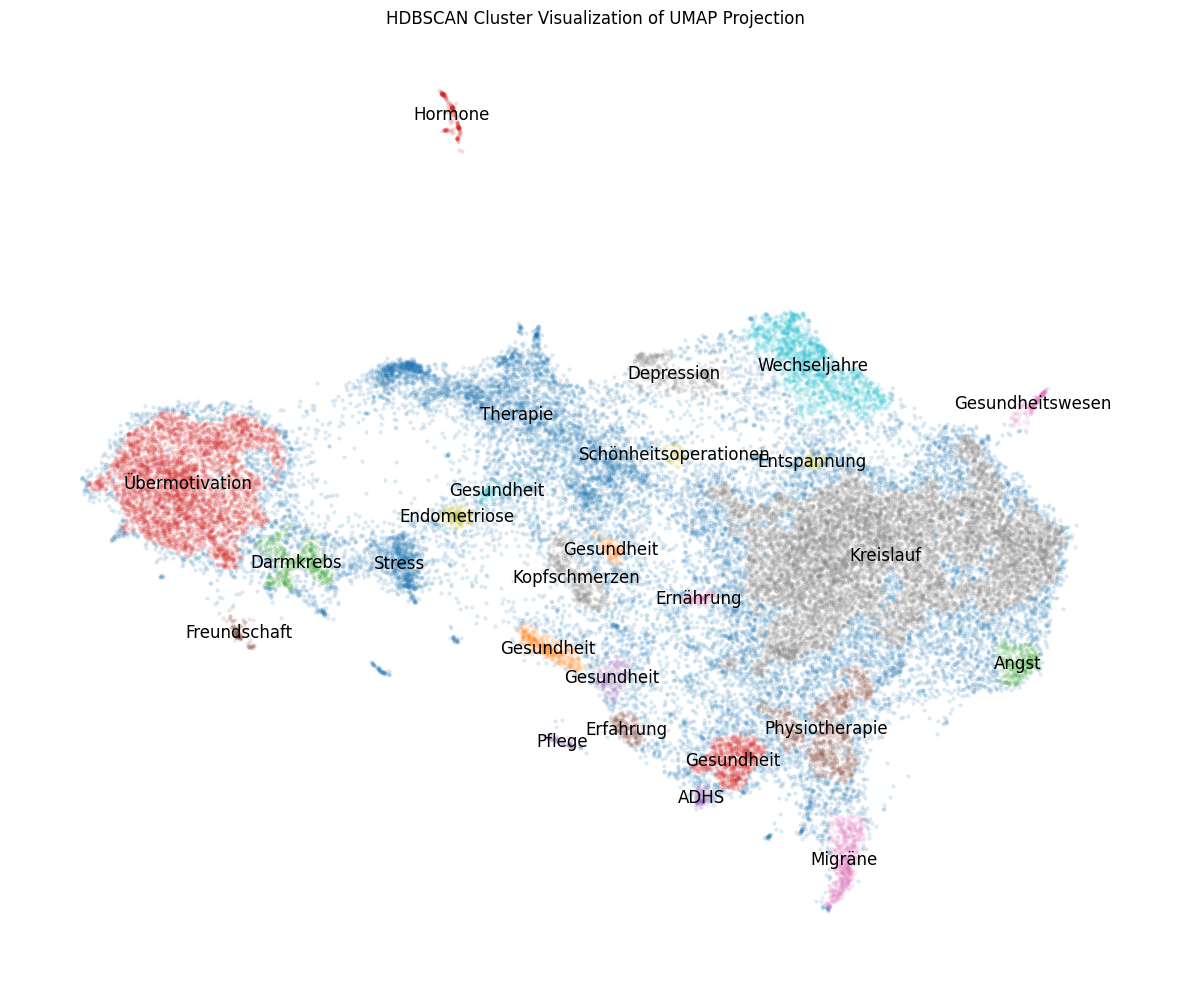

In [ ]:
# visualize clusters

plt.figure(figsize=(10, 8))

unique_clusters = np.unique(clustering)
n_clusters = len(unique_clusters)


def generate_distinct_colors(n):
    colors = plt.cm.rainbow(np.linspace(0, 1, n))
    return ListedColormap(colors)


custom_cmap = generate_distinct_colors(n_clusters)

fig, ax = plt.subplots(figsize=(12, 10))

x_min, x_max = plt.xlim(-8, 8)
y_min, y_max = plt.ylim(-6, 7)


for cluster in unique_clusters:
    embeddings = embeddings_2d[clustering == cluster]

    valid_indices = (
        (embeddings[:, 0] >= x_min)
        & (embeddings[:, 0] <= x_max)
        & (embeddings[:, 1] >= y_min)
        & (embeddings[:, 1] <= y_max)
    )

    embeddings = embeddings[valid_indices]

    scatter = ax.scatter(
        embeddings[:, 0],
        embeddings[:, 1],
        marker=".",
        s=20,
        alpha=0.1,
        label=f"cluster {cluster}",
    )

    centroid_x = np.mean(embeddings[:, 0])
    centroid_y = np.mean(embeddings[:, 1])

    # plt.text(centroid_x, centroid_y, str(cluster), fontsize=12, ha='center', va='center')
    plt.text(
        centroid_x,
        centroid_y,
        f"{terms[cluster]}",
        fontsize=12,
        ha="center",
        va="center",
    )

ax.set_title("HDBSCAN Cluster Visualization of UMAP Projection")
plt.axis("off")

plt.tight_layout()
plt.show()